In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cell2location
import scvi
import os
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
import seaborn as sns
import time
import gc
gc.collect()


/Users/onkiwong/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


88053

In [8]:
DATA_DIR = '/Users/onkiwong/Documents/GitHub/Spatial_Transcriptomics_Deconvolution_Algorithm_Benchmarking/methods/cell2loc/datasets'
sp09 = os.path.join(DATA_DIR, 'GSM7090362_SpPat09_Unaffected.csv')
sp10 = os.path.join(DATA_DIR, 'GSM7090365_SpPat10_Unaffected.csv')
sp11 = os.path.join(DATA_DIR, 'GSM7090368_SpPat15_Unaffected.csv')

In [25]:
# check the overlapping columns between sp09, sp10, sp11 and cellexp.csv
# cellexp = pd.read_csv(os.path.join(DATA_DIR, 'cellexp.csv'))
# sp09 = pd.read_csv(sp09)
# sp10 = pd.read_csv(sp10)
# sp11 = pd.read_csv(sp11)

In [27]:
# set index to the first column and drop the first column
sp09 = sp09.set_index('0')
sp10 = sp10.set_index('0')
sp11 = sp11.set_index('0')

In [30]:
# check the overlapping columns between sp09, sp10, sp11 and cellexp.csv
print(len(set(sp09.columns) & set(cellexp.columns)))
print(len(set(sp10.columns) & set(cellexp.columns)))
print(len(set(sp11.columns) & set(cellexp.columns)))

191
191
191


In [34]:
# keep the overlapping columns
sp09 = sp09[list(set(sp09.columns) & set(cellexp.columns))]
sp10 = sp10[list(set(sp10.columns) & set(cellexp.columns))]
sp11 = sp11[list(set(sp11.columns) & set(cellexp.columns))]

In [36]:
sp09.to_csv(os.path.join(DATA_DIR, 'GSM7090362_SpPat09_Unaffected.csv'), index=True, header=True)
sp10.to_csv(os.path.join(DATA_DIR, 'GSM7090365_SpPat10_Unaffected.csv'), index=True, header=True)
sp11.to_csv(os.path.join(DATA_DIR, 'GSM7090368_SpPat15_Unaffected.csv'), index=True, header=True)

In [43]:
cellexp
ref_exp = cellexp.T

In [45]:
ref_exp.columns = ref_exp.iloc[0]
ref_exp = ref_exp[1:]
ref_exp.head()

cellID,GCAGCCATCGGCCGAT-1-1,GCGGGTTAGGAGTTTA-1,GCGCGATTCTAGCACA-1,GCGCGATTCGCAAGCC-1,GCGCGATTCATATCGG-1,GCGCGATAGGTCATCT-1,GCGCGATAGGTAGCTG-1,GCGCGATAGCTGAAAT-1,GCGCCAATCCAAATGC-1,GCGCCAAGTTACTGAC-1,...,GGGTCTGGTTAAGATG-1,TTTCCTCGTAAGGGAA-1,TTTATGCGTGGTAACG-1,TGCCCTATCGGCTACG-1,TTTATGCAGTATTGGA-1,CGCTATCTCGCGCCAA-1,TACACGAAGTAGGCCA-1-1,CCCTCCTGTCAAAGAT-1,CAAGGCCTCTCGCATC-1,CAAGGCCGTACGCTGC-1
RSRP1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,0,1,0
RPL14,3,3,3,3,2,2,2,3,2,2,...,3,2,2,3,3,2,3,3,3,3
XIST,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
PSAP,1,1,1,1,1,1,0,0,1,1,...,1,1,1,1,1,0,1,0,1,1
COTL1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [48]:
# write ref_exp to a txt file
ref_exp.to_csv(os.path.join(DATA_DIR, 'cellexp.txt'), sep='\t')

In [49]:
sp09 = pd.read_csv(os.path.join(DATA_DIR, 'GSM7090362_SpPat09_Unaffected.csv'))
sp10 = pd.read_csv(os.path.join(DATA_DIR, 'GSM7090365_SpPat10_Unaffected.csv'))
sp11 = pd.read_csv(os.path.join(DATA_DIR, 'GSM7090368_SpPat15_Unaffected.csv'))

sp09.head()

,0,NPC2,CD8A,GNLY,COTL1,CD3D,RPL11,FCGR3A,FAM210B,BRI3,...,CD8B,CST3,GZMA,MT-ATP6,RPL30,HLA-DRA,MT-CYB,TRAC,LYAR,SERPINA1
0,AAACGAGACGGTTGAT-1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,12.0,0.0,0.0,4.0,0.0,0.0,0.0
1,AAAGGGATGTAGCAAG-1,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,...,0.0,1.0,0.0,14.0,3.0,4.0,7.0,0.0,0.0,0.0
2,AAATGGTCAATGTGCC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,1.0,2.0,0.0,0.0,0.0
3,AACAACTGGTAGTTGC-1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,13.0,0.0,0.0,3.0,0.0,0.0,0.0
4,AACAATTACTCTACGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0


In [50]:
sp09 = sp09.set_index('0')
sp10 = sp10.set_index('0')
sp11 = sp11.set_index('0')

sp09 = sp09.T
sp10 = sp10.T
sp11 = sp11.T

sp09.head()

0,AAACGAGACGGTTGAT-1,AAAGGGATGTAGCAAG-1,AAATGGTCAATGTGCC-1,AACAACTGGTAGTTGC-1,AACAATTACTCTACGC-1,AACAGGATGGGCCGCG-1,AACCAAGACTTCTCTG-1,AACCGAGCTTGGTCAT-1,AACGATAGAAGGGCCG-1,AACGATATGTCAACTG-1,...,TTGCTGCACCTATCCA-1,TTGGCTCGCATGAGAC-1,TTGGGACACTGCCCGC-1,TTGGGCGGCGGTTGCC-1,TTGTAAGGCCAGTTGG-1,TTGTAATCCGTACTCG-1,TTGTCGTTCAGTTACC-1,TTGTTAGCAAATTCGA-1,TTGTTCAGTGTGCTAC-1,TTGTTGTGTGTCAAGA-1
NPC2,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,...,3.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,1.0,0.0
CD8A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GNLY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
COTL1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CD3D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
sp09.to_csv(os.path.join(DATA_DIR, 'GSM7090362_SpPat09_Unaffected.txt'), sep='\t')
sp10.to_csv(os.path.join(DATA_DIR, 'GSM7090365_SpPat10_Unaffected.txt'), sep='\t')
sp11.to_csv(os.path.join(DATA_DIR, 'GSM7090368_SpPat15_Unaffected.txt'), sep='\t')

In [52]:
# DATA_DIR = '/Users/onkiwong/Documents/GitHub/Spatial_Transcriptomics_Deconvolution_Algorithm_Benchmarking/seqFISH'
# cellcount = os.path.join(DATA_DIR, "raw_somatosensory_sc_exp.csv")
# sp_data = os.path.join(DATA_DIR, "Out_gene_expressions_10000genes.txt")
# celltype = os.path.join(DATA_DIR, "somatosensory_sc_labels.txt")

DATA_DIR = '/Users/onkiwong/Documents/GitHub/Spatial_Transcriptomics_Deconvolution_Algorithm_Benchmarking/methods/cell2loc/datasets'
cellcount = os.path.join(DATA_DIR, "cellexp.csv")
sp_data = os.path.join(DATA_DIR, "GSM7090362_SpPat09_Unaffected.txt")
celltype = os.path.join(DATA_DIR, "celltypes.txt")

In [71]:
start_time = time.time()
adata_ref = sc.read_csv(cellcount)
# adata_ref = adata_ref.transpose()

In [72]:
adata_ref

AnnData object with n_obs × n_vars = 4250 × 192

In [73]:

df_celltype = pd.read_csv(celltype, header=None, sep='\t')
df_celltype.columns = ['celltype']
df_celltype.head()

,celltype
0,Activated NK cells
1,Activated NK cells
2,Activated NK cells
3,Activated NK cells
4,Activated NK cells


In [74]:
df_celltype.shape

(4250, 1)

In [75]:

df_celltype.index = adata_ref.obs.index
adata_ref.obs['Subset'] = df_celltype['celltype']
adata_ref.obs['Sample'] = adata_ref.obs_names
adata_ref.obs['Sample'] = adata_ref.obs['Sample'].apply(lambda x: x[0:4])
print('Input reference data:')
print(adata_ref)

Input reference data:
AnnData object with n_obs × n_vars = 4250 × 192
    obs: 'Subset', 'Sample'


/Users/onkiwong/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


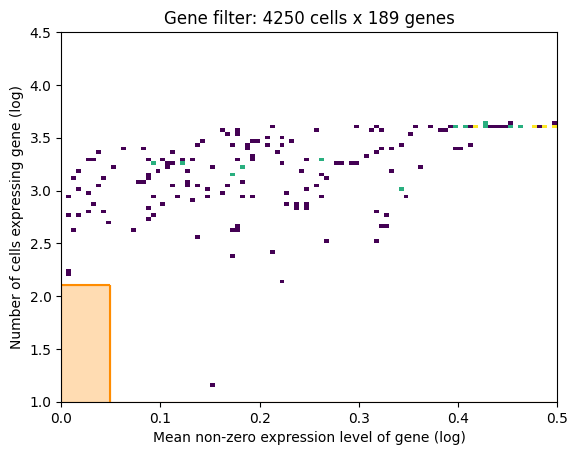

In [76]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
# 5, 0.03, 1.12

# In our case, a few genes are cut
adata_ref = adata_ref[:, selected].copy()

In [77]:
adata_ref

AnnData object with n_obs × n_vars = 4250 × 189
    obs: 'Subset', 'Sample'
    var: 'n_cells', 'nonz_mean'

/Users/onkiwong/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/data/fields/_dataframe_field.py:186: UserWarning: Category 11 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/onkiwong/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/onkiwong/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/Users/onkiwong/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottl

Epoch 250/250: 100%|██████████| 250/250 [00:09<00:00, 27.35it/s, v_num=1, elbo_train=7.85e+5]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [00:09<00:00, 27.04it/s, v_num=1, elbo_train=7.85e+5]


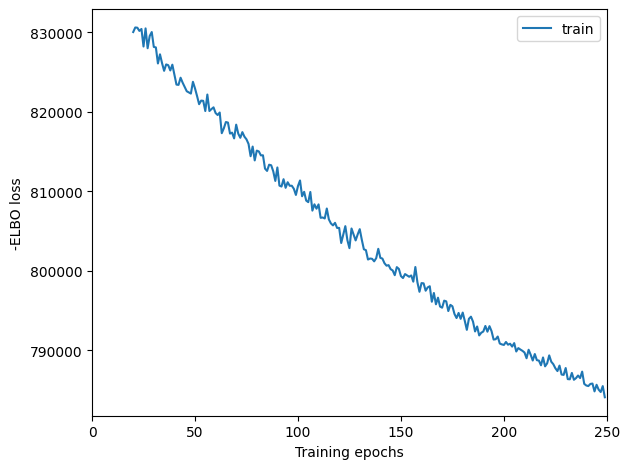

In [78]:
from cell2location.models import RegressionModel
RegressionModel.setup_anndata(adata=adata_ref, batch_key='Sample', labels_key='Subset')
mod = RegressionModel(adata_ref)
# Use all data for training (validation not implemented yet, train_size=1)
mod.train(max_epochs=250, batch_size=None, train_size=1, lr=0.002)
# plot ELBO loss history during training, removing first 20 epochs from the plot
ELBO_plot = mod.plot_history(20)

Sampling global variables, sample: 100%|██████████| 999/999 [00:03<00:00, 260.29it/s]
Saved reference signatures file: 
/Users/onkiwong/Documents/GitHub/Spatial_Transcriptomics_Deconvolution_Algorithm_Benchmarking/methods/cell2loc/sc.h5ad


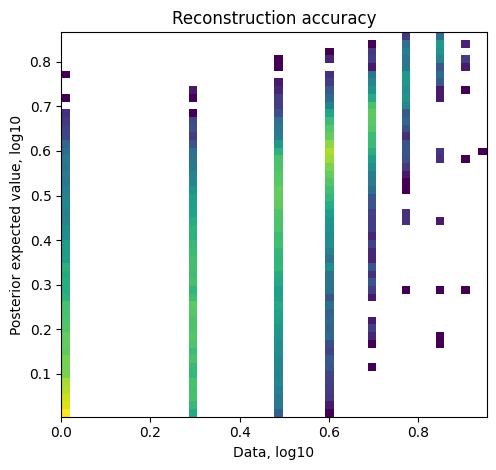

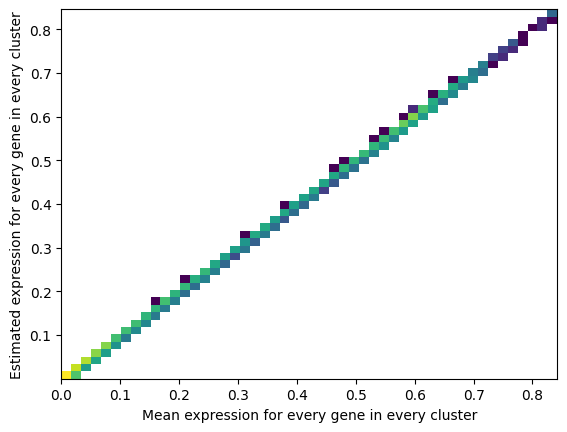

In [79]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500}
)
# Results saving folder
# Save model
mod.save(f"{os.getcwd()}", overwrite=True)

adata_file = f"{os.getcwd()}/sc.h5ad"
adata_ref.write(adata_file)
print("Saved reference signatures file: ")
print(adata_file)

# First plot: Reconstruction accuracy to assess if there are any issues with inference
# Second plot: When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, density everywhere) it indicates problems with signature estimation.
mod.plot_QC()

In [154]:
# Export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

# Note that the column names are cell types, the row names are gene names, in the original code
# the authors use ENSEMBL as names instead of raw gene names

,Activated NK cells,CD4+ effector cells,Dendritic cells,Differenting myeloid cells,Granulocytes
RSRP1,0.893527,0.723933,0.591669,0.696884,0.491517
RPL14,2.472966,2.726269,2.808234,1.861539,2.556985
XIST,0.000167,0.662449,0.208999,1.001380,0.550573
PSAP,0.696860,0.544810,0.529849,2.509620,1.208651
COTL1,0.092806,0.266008,0.535265,2.006013,1.212308


In [155]:
inf_aver.index

Index(['RSRP1', 'RPL14', 'XIST', 'PSAP', 'COTL1', 'GZMA', 'C12orf75',
       'SLC25A37', 'RPS3A', 'NCOA4',
       ...
       'HLA-C', 'HLA-DRA', 'GNG11', 'TRAC', 'POLR2J3-1', 'CD37', 'TUBB1',
       'RPS29', 'RPS3', 'RPL15'],
      dtype='object', length=189)

In [173]:
adata_vis = sc.read_text(sp_data).T
adata_vis.obs['sample'] = 'marker_genes'

In [175]:
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

In [180]:
cell2location.models.Cell2location.setup_anndata(adata=adata_vis[:, intersect], batch_key='sample')

/Users/onkiwong/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/cell2location/models/_cell2location_model.py:151: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["_indices"] = np.arange(adata.n_obs).astype("int64")


In [185]:
from cell2location.models import Cell2location

In [187]:
cell2location.models.Cell2location.setup_anndata(adata_vis)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/onkiwong/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/onkiwong/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/Users/onkiwong/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/onkiwong/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batc

Epoch 20000/20000: 100%|██████████| 20000/20000 [07:16<00:00, 45.93it/s, v_num=1, elbo_train=1.09e+5]

`Trainer.fit` stopped: `max_epochs=20000` reached.


Epoch 20000/20000: 100%|██████████| 20000/20000 [07:16<00:00, 45.86it/s, v_num=1, elbo_train=1.09e+5]


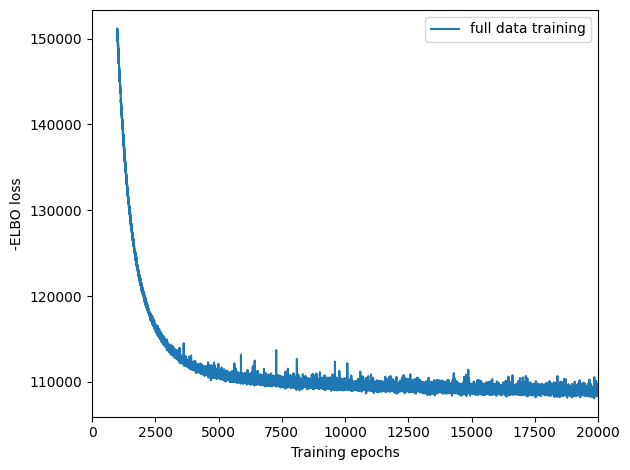

In [188]:
gc.collect()
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=6,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=200
)

mod.train(max_epochs=20000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training'])

In [189]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs}
)

Sampling global variables, sample: 100%|██████████| 999/999 [00:04<00:00, 210.44it/s]


In [190]:
# Save model
run_name = f'{os.getcwd()}/cell2location_map'

mod.save(run_name, overwrite=True)
end_time = time.time()

In [191]:
# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

'/Users/onkiwong/Documents/GitHub/Spatial_Transcriptomics_Deconvolution_Algorithm_Benchmarking/methods/cell2loc/cell2location_map/sp.h5ad'

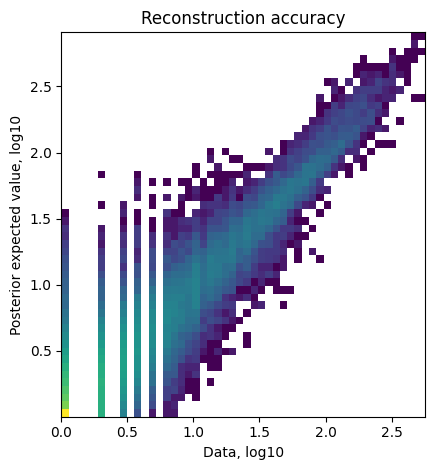

In [192]:
# Examine reconstruction accuracy to assess if there are any issues with mapping
# the plot should be roughly diagonal, strong deviations will signal problems
mod.plot_QC()

In [193]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']
result1 = adata_vis.obsm['q05_cell_abundance_w_sf']
result2 = adata_vis.obsm['q95_cell_abundance_w_sf']
result3 = adata_vis.obsm['means_cell_abundance_w_sf']
# result_mean = result3.to_csv('mean_gene_expressionhalfx.csv')
# result2.to_csv('95_gene_expressionhalfx.csv')
# result1.to_csv('05_gene_expressionhalfx.csv')

In [194]:
sum_result_3 = result3.sum(axis=1)
result3_percent = result3.div(result3.assign(total=sum_result_3)['total'], axis='index')
result_name = os.path.join(os.getcwd(), "Cell2location.csv")
result3_percent.to_csv(result_name)

In [195]:
print("Total time comsuption: seconds")
print(end_time - start_time)

Total time comsuption: seconds
2303.2526750564575
